In [ ]:
!unzip '/content/drive/MyDrive/Capsule Endoscopy-images.zip' -d '/content/drive/MyDrive'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Capsule Endoscopy-images/Pylorus/131368cc17e44240_1229.jpg  
  inflating: /content/drive/MyDrive/Capsule Endoscopy-images/Pylorus/131368cc17e44240_1230.jpg  
  inflating: /content/drive/MyDrive/Capsule Endoscopy-images/Pylorus/131368cc17e44240_1231.jpg  
  inflating: /content/drive/MyDrive/Capsule Endoscopy-images/Pylorus/131368cc17e44240_1232.jpg  
  inflating: /content/drive/MyDrive/Capsule Endoscopy-images/Pylorus/131368cc17e44240_1233.jpg  
  inflating: /content/drive/MyDrive/Capsule Endoscopy-images/Pylorus/131368cc17e44240_1234.jpg  
  inflating: /content/drive/MyDrive/Capsule Endoscopy-images/Pylorus/131368cc17e44240_1235.jpg  
  inflating: /content/drive/MyDrive/Capsule Endoscopy-images/Pylorus/131368cc17e44240_1236.jpg  
  inflating: /content/drive/MyDrive/Capsule Endoscopy-images/Pylorus/131368cc17e44240_1237.jpg  
  inflating: /content/drive/MyDrive/Capsule Endoscopy-images/Pylorus/131368c

In [ ]:
import os
import random
import numpy as np
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Set a random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
# Define paths and parameters
data_dir = "/content/drive/MyDrive/Capsule Endoscopy-images"
save_model_path = "/content/drive/MyDrive/FewshotModel_1.pth"
image_size = 224
num_classes = 14
num_shots = 5
num_query_samples = 5
batch_size = 32
num_epochs = 20
learning_rate = 0.001

In [ ]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(self.classes)}
        self.samples = self.load_samples()

    def load_samples(self):
        samples = []
        for cls in self.classes:
            class_path = os.path.join(self.data_dir, cls)
            # Use glob to get a list of files
            images = glob(os.path.join(class_path, '*'))
            for img in images:
                samples.append((img, self.class_to_idx[cls]))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
# Visualize images from each class
def visualize_samples(dataset):
    fig, axes = plt.subplots(2, 7, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        img, label = dataset[i]
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.set_title(dataset.idx_to_class[label])
        ax.axis("off")
    plt.show()

In [ ]:
# Split dataset into train and test sets
def split_dataset(dataset, test_size=0.2):
    num_samples = len(dataset)
    indices = list(range(num_samples))
    split = int(np.floor(test_size * num_samples))
    random.shuffle(indices)
    train_indices, test_indices = indices[split:], indices[:split]
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)
    return train_dataset, test_dataset

In [ ]:
# Prototypical Network Model
class PrototypicalNet(nn.Module):
    def __init__(self, num_classes, feature_dim=512):
        super(PrototypicalNet, self).__init__()
        self.encoder = models
        in_features = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        self.fc = nn.Linear(in_features, feature_dim)
        self.prototypes = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# Set up data transforms
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

In [ ]:
# Create the dataset
dataset = CustomDataset(data_dir, transform=transform)

In [ ]:
# Split dataset into train and test sets
train_dataset, test_dataset = split_dataset(dataset, test_size=0.2)

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Initialize the Prototypical Network model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PrototypicalNet(num_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.1MB/s]


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/20], Loss: 0.44293067695464144
Epoch [2/20], Loss: 0.19974433971217231
Epoch [3/20], Loss: 0.1321674972282885
Epoch [4/20], Loss: 0.09728393118428721
Epoch [5/20], Loss: 0.07551857127447649
Epoch [6/20], Loss: 0.06153634589387831
Epoch [7/20], Loss: 0.04785581634381747
Epoch [8/20], Loss: 0.043623365394081674
Epoch [9/20], Loss: 0.033441113222775196
Epoch [10/20], Loss: 0.033517145271410365
Epoch [11/20], Loss: 0.030596522271719856
Epoch [12/20], Loss: 0.026311452956469313
Epoch [13/20], Loss: 0.028969360889384642
Epoch [14/20], Loss: 0.018770988388041202
Epoch [15/20], Loss: 0.020323281463328065
Epoch [16/20], Loss: 0.02148057760144682
Epoch [17/20], Loss: 0.020459623322285268
Epoch [18/20], Loss: 0.014360253264823196
Epoch [19/20], Loss: 0.018207894399392553
Epoch [20/20], Loss: 0.015068858116188341


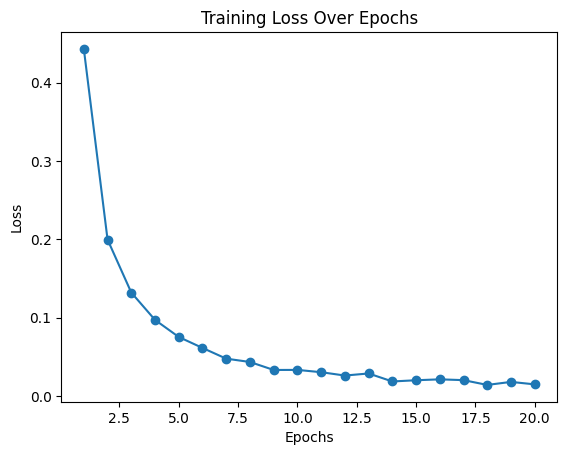

In [ ]:
# Training the model
losses = []  # to store the losses for plotting

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}")

# Plot the loss graph
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9840160897639463


In [ ]:
# Save the model
torch.save(model.state_dict(), save_model_path)

In [ ]:
# Load the saved model
model.load_state_dict(torch.load(save_model_path))
model.eval()

PrototypicalNet(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Test Accuracy: 0.9840160897639463
Precision: 0.9247241104544124
Recall: 0.9355319895339583
F1 Score: 0.9165941067374531


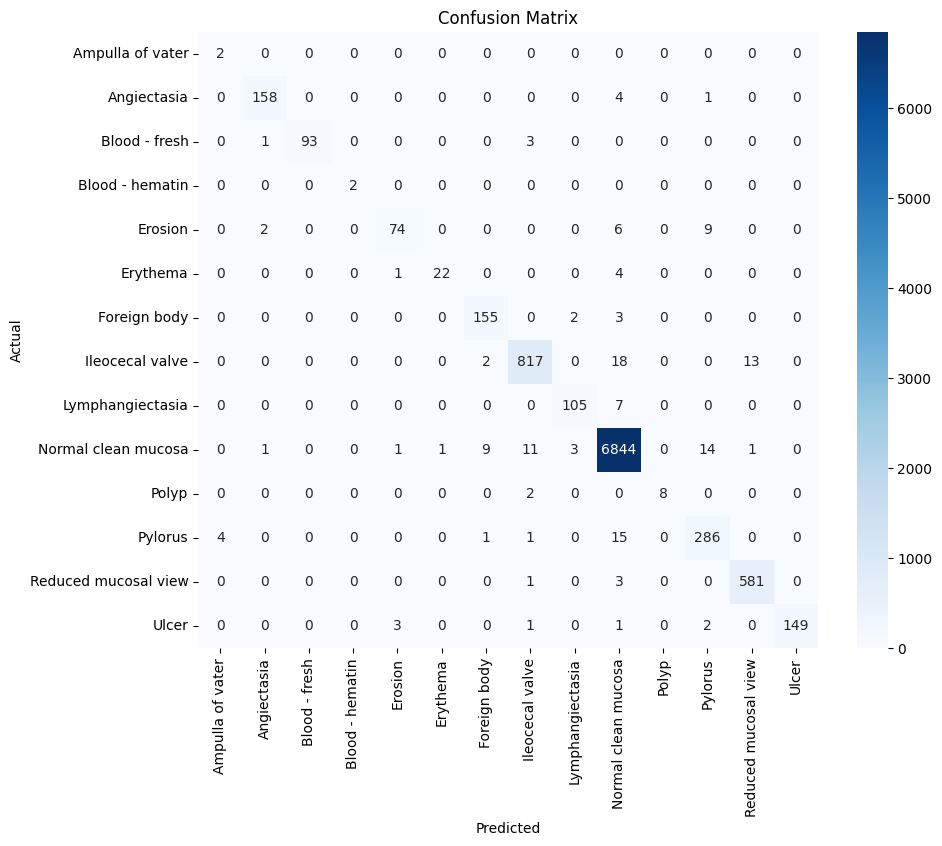

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# ... (previous code)

# Evaluation
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = correct / total
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Function to predict the class of a given image
def predict_class(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output.data, 1)
    return dataset.idx_to_class[predicted.item()]

In [ ]:
# Example usage
image_path_to_predict = "/content/drive/MyDrive/Capsule Endoscopy-images/Normal clean mucosa/3ada4222967f421d_5602.jpg"
predicted_class = predict_class(image_path_to_predict)
print(f"The predicted class for the given image is: {predicted_class}")

The predicted class for the given image is: Normal clean mucosa


In [ ]:
image_size = 224
num_classes = 14

# Data transforms setup
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load the model
def load_model(model_path):
    model = PrototypicalNet(num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to predict the class of an image using a loaded model
def predict_image(model, img_path, transform):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output.data, 1)

    return predicted.item()

# Define the paths for the saved model and test image
saved_model_path = "/content/drive/MyDrive/FewshotModel.pth"
test_img_path = "/content/drive/MyDrive/test/Ampulla of vater/eb0203196e284797_1157.jpg"

# Load the model
model = load_model(saved_model_path)

# List of class names corresponding to numerical indices
class_names = ['Ampulla of vater', 'Angiectasia', 'Blood - fresh', 'Blood - hematin', 'Erosion', 'Erythema', 'Foreign body', 'Ileocecal valve', 'Lymphangiectasia', 'Normal clean mucosa', 'Polyp', 'Pylorus', 'Reduced mucosal view', 'Ulcer']

# Perform the prediction
predicted_class = predict_image(model, test_img_path, transform)
predicted_class_name = class_names[predicted_class]
print(f"Predicted Class: {predicted_class_name}")

Predicted Class: Ampulla of vater
